In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import datetime

2025-11-11 10:18:06.346602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Dataset parameters
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds = tf.keras.utils.image_dataset_from_directory(
    "./data", 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    validation_split=0.3,
    subset="training",
    seed=123,
)

Found 420 files belonging to 11 classes.
Using 294 files for training.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "./data", 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    validation_split=0.3,
    subset="validation",
    seed=123,
)

Found 420 files belonging to 11 classes.
Using 126 files for validation.


In [4]:
class_names = train_ds.class_names
class_names

['allen key',
 'chisel',
 'file',
 'hammer',
 'mallet',
 'plier',
 'saw',
 'scrapper',
 'screw driver flat',
 'screw driver star',
 'spanner']

2025-11-11 10:18:15.367788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


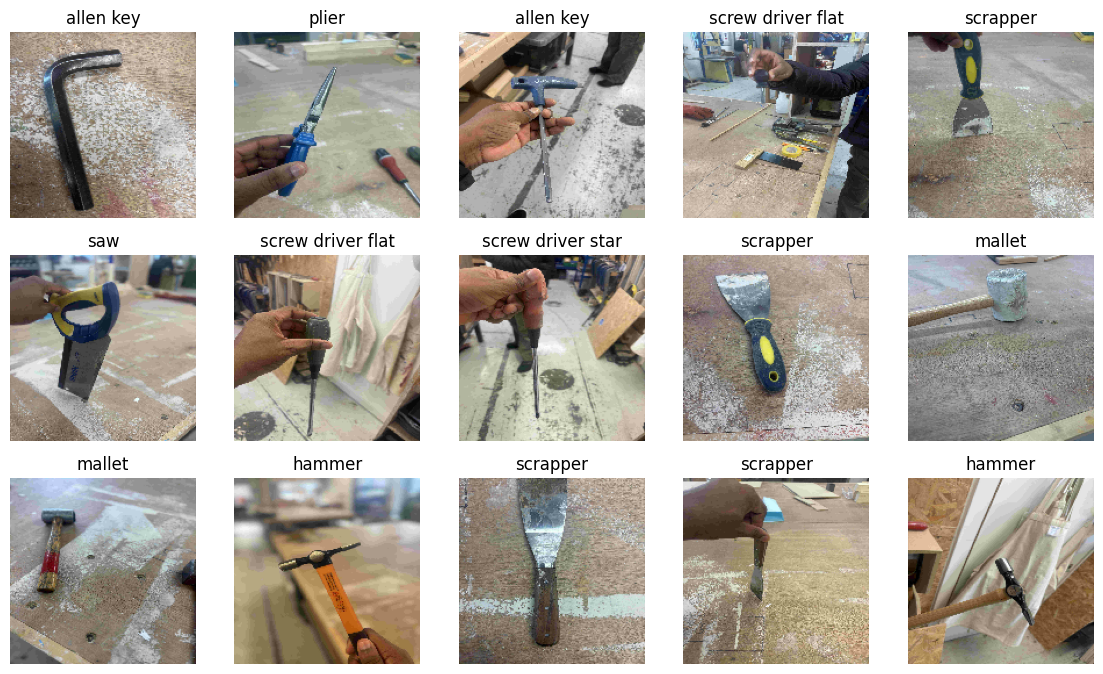

In [5]:
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# Split the validation set into validation and test

test_dataset = val_ds.take(2)
validation_dataset = val_ds.skip(2)

In [7]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 10
Number of validation batches: 2
Number of test batches: 2


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in this tutorial.

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2),
])

2025-11-11 10:18:19.155519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


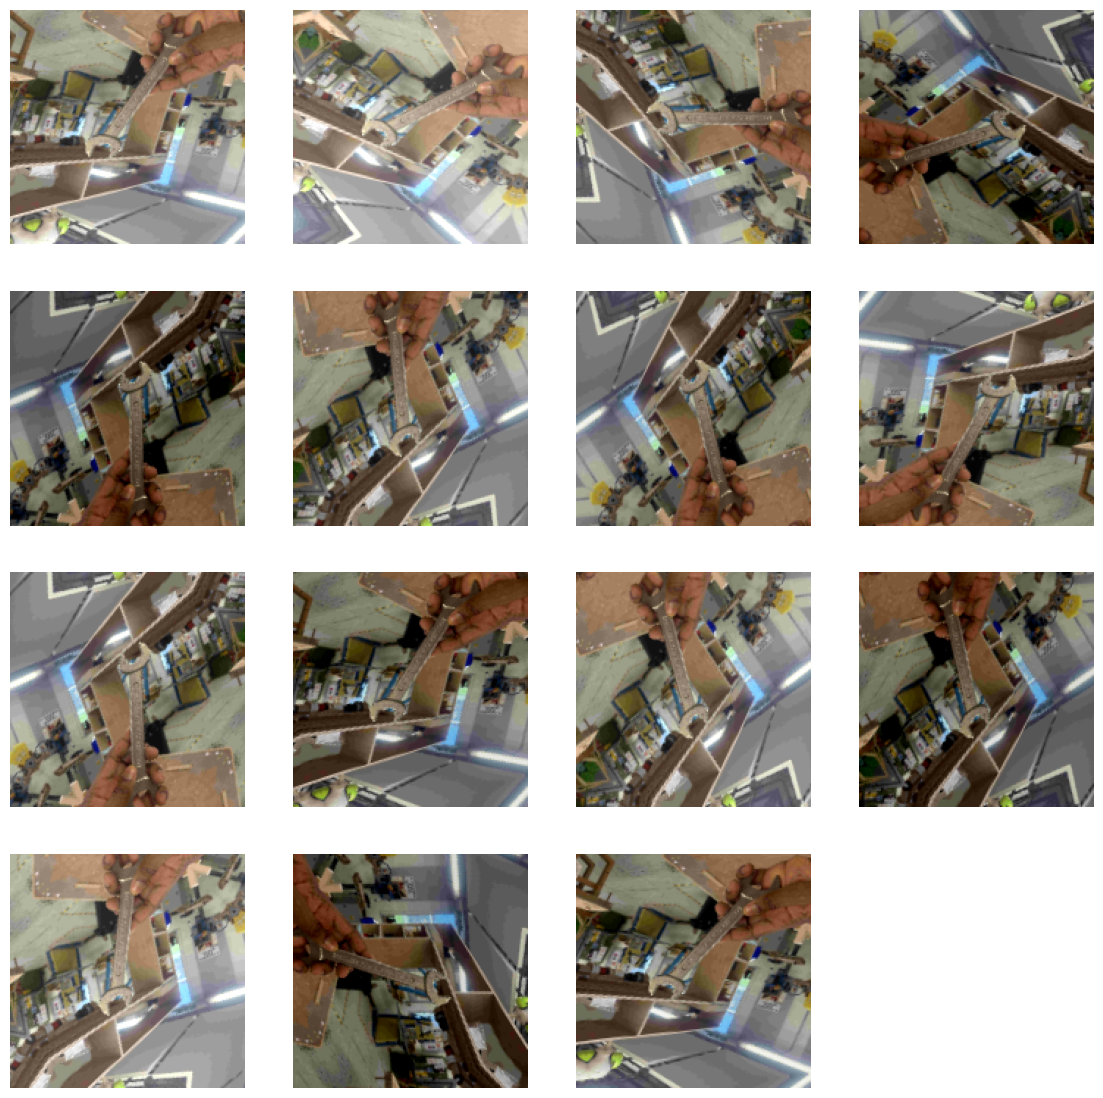

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(14, 14))
  first_image = image[0]
  for i in range(15):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Building the models



In [11]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


def imagenet_model(is_mobilenet, base_learning_rate):
    rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
    # Create the base model from the pre-trained model MobileNet V2
    IMAGE_SHAPE = IMG_SIZE + (3,)

    if is_mobilenet:
        base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    else:
        base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    image_batch, label_batch = next(iter(train_dataset))
    feature_batch = base_model(image_batch)
    base_model.trainable = False # Freeze all the layers of the model
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    prediction_layer = tf.keras.layers.Dense(11, activation='softmax')
    prediction_batch = prediction_layer(feature_batch_average)
    
    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

        

### Model Test

In [12]:
learning_rate = 0.0001
mobile_netv2 = imagenet_model(True, learning_rate)
inception_v3 = imagenet_model(False, learning_rate)

In [13]:
initial_epochs = 100

loss0, accuracy0 = mobile_netv2.evaluate(validation_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 961ms/step - accuracy: 0.0645 - loss: 2.8987


In [14]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.90
initial accuracy: 0.06


In [ ]:
history_mobile_netv2 = mobile_netv2.fit(
    train_dataset, 
    epochs=initial_epochs, 
    validation_data=validation_dataset, 
    callbacks=tensorboard_callback
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1346 - loss: 2.7945

In [ ]:
history_inception_v3 = inception_v3.fit(
    train_dataset, 
    epochs=initial_epochs, 
    validation_data=validation_dataset,
    call_backs=tensorboard_callback
)

In [ ]:
def plot_train_val_stat(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    

In [ ]:
plot_train_val_stat(history_mobile_netv2)

In [ ]:
plot_train_val_stat(history_inception_v3)

In [ ]:
def make_predictions(model):
    loss, accuracy = model.evaluate(test_dataset)
    print('Test accuracy :', accuracy, "Test loss : ", )
    # Retrieve a batch of images from the test set
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()
    predictions = model.predict_on_batch(image_batch)
    
    prediction_val = []
    
    for x in predictions:
        x_list = x.flatten().tolist()
        prediction_val.append(x_list.index(max(x_list)))
    
    print('Predictions:\n', prediction_val)
    print('Labels:\n', label_batch)
    
    plt.figure(figsize=(15, 15))
    for i in range(15):
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(class_names[prediction_val[i]])
      plt.axis("off")

    return (label_batch, prediction_val)

In [ ]:
mobile_netv2_pred = make_predictions(mobile_netv2)

In [ ]:
inception_netv2_pred = make_predictions(inception_v3)

In [ ]:
tf.math.confusion_matrix(
    mobile_netv2_pred[0],
    mobile_netv2_pred[1],
    num_classes=11,
    dtype=tf.dtypes.int32,
    name=None
)